In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import random
import PIL

from datasets import DataImageNet 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [21]:
# download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True).features

# don't train the model
for param in model.parameters():
    param.requires_grad = False

In [107]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        # T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        # T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def extract_features(images, model):
    feats = [images]
    for i, layer in enumerate(model._modules.values()):
        feats.append(layer(feats[i]))
    return feats

def extract_gram(feat, normalize=True):
    N, C, H, W = feat.shape
    feat = feat.view(N, C, -1)
    gram = torch.zeros([N, C, C])
    for i in range(N):
        gram[i] = torch.mm(feat[i], feat[i].t())
    
    if normalize:
        gram = gram / (H * W * C)
    
    return gram

def extract_grams(feats, normalize=True):
    grams = []
    for feat in feats:
        grams.append(extract_gram(feat, normalize))
    return grams

In [34]:
def content_loss(weight, feats, target_feats, target_layer):
    loss = (feats[target_layer] - target_feats[target_layer]).norm() ** 2
    return weight * loss

def style_loss(weights, feats, target_grams, target_layers):
    loss = 0
    for i, idx in enumerate(target_layers):
        loss += weights[i] * (extract_gram(feats[idx]) - target_grams[idx]).norm() ** 2
    return loss

def tv_loss(weight, images):
    loss1 = (images[:, :, 1:, :] - images[:, :, :-1, :]).norm() ** 2
    loss2 = (images[:, :, :, 1:] - images[:, :, :, :-1]).norm() ** 2
    return weight * (loss1 + loss2)

In [109]:
def show_images(content_img, style_img):
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    if content_img is not None:
        axarr[0].imshow(deprocess(content_img))
    if style_img is not None:
        axarr[1].imshow(deprocess(style_img))
    plt.show()
    
def show_image(img):
    plt.figure()
    plt.axis('off')
    plt.imshow(deprocess(img))
    plt.show()
    
def style_transfer(model, content_image, style_image, 
                   content_layer, content_weight,
                   style_layers, style_weights, 
                   tv_weight, init_random = False):
    
    # change model to 'test' mode
    model.eval()
    
    # get target features and grams
    content_feats = extract_features(content_image, model)
    style_feats = extract_features(style_image, model)
    style_grams = extract_grams(style_feats)
    
    # init image
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1)
    else:
        img = content_image.clone()
        
    img.requires_grad_()
    
    # optimizer hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180
    
    # init optimizer
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    # train
    for t in range(230):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        
        # features
        feats = extract_features(img, cnn)
        
        # loss
        c_loss = content_loss(content_weight, feats, content_feats, content_layer)
        s_loss = style_loss(style_weights, feats, style_grams, style_layers)
        t_loss = tv_loss(tv_weight, img)
        loss = c_loss + s_loss + t_loss
        
        loss.backward()
        
        # gradient descents
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
            
        optimizer.step()
        optimizer.zero_grad()
        
        # show image
        if t % 30 == 0:
            print('After', t + 1, 'iteration:')
            show_image(img.data)
        
    # return
    return img.data

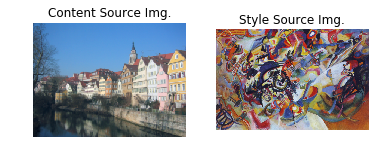

After 1 iteration:


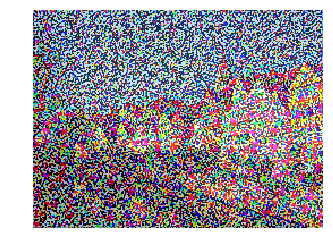

After 31 iteration:


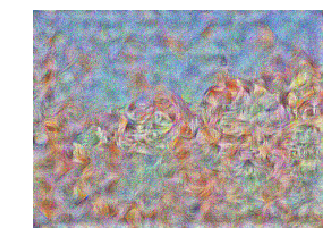

After 61 iteration:


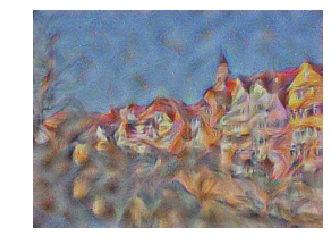

After 91 iteration:


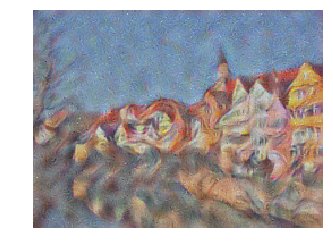

After 121 iteration:


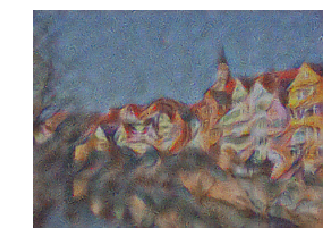

After 151 iteration:


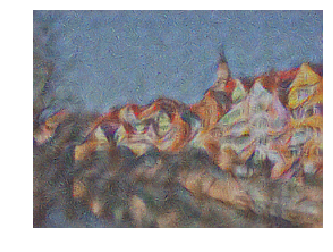

After 181 iteration:


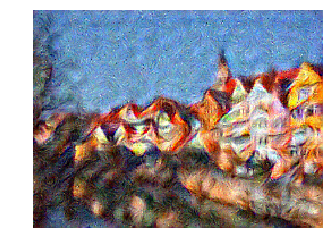

After 211 iteration:


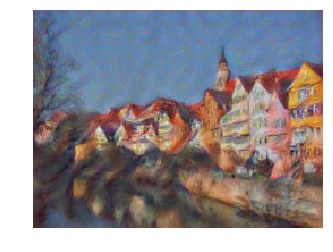

Final image:


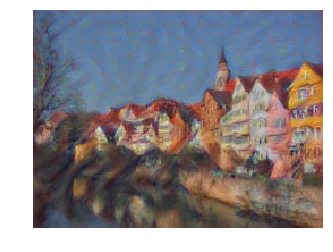

In [110]:
# get content and style images
content_image = preprocess(PIL.Image.open('./datasets/style_images/tubingen.jpg'), 192)
style_image = preprocess(PIL.Image.open('./datasets/style_images/composition_vii.jpg'), 512)

# show original images
show_images(content_image, style_image)

# Composition VII + Tubingen
params1 = {
    'model': model,
    'content_image' : content_image,
    'style_image' : style_image,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [20000, 500, 12, 1],
    'tv_weight' : 5e-2
}

image = style_transfer(**params1)

# show combined results
print('Final image:')
show_image(image)

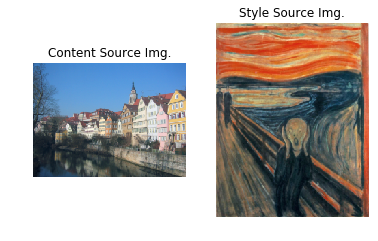

After 1 iteration:


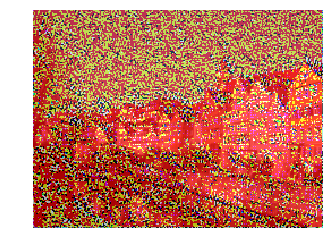

After 31 iteration:


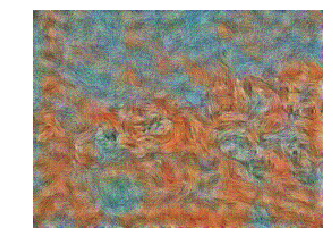

After 61 iteration:


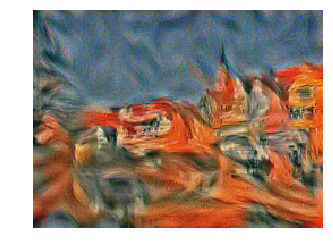

After 91 iteration:


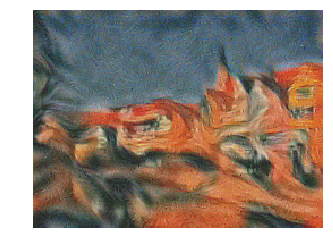

After 121 iteration:


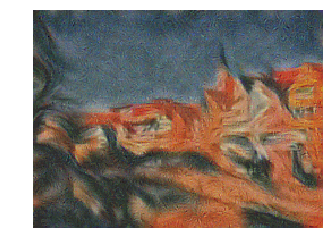

After 151 iteration:


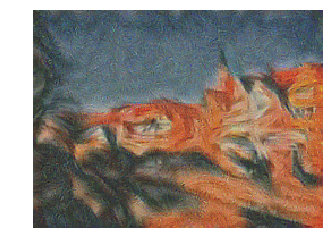

After 181 iteration:


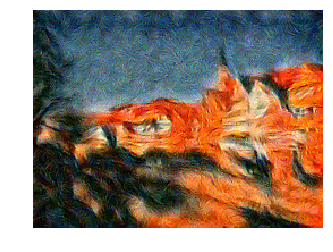

After 211 iteration:


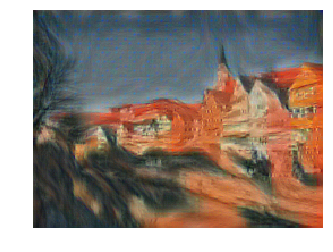

Final image:


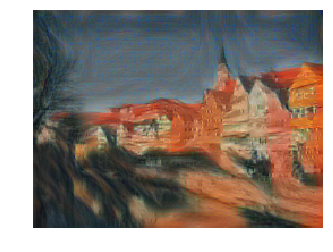

In [111]:
# get content and style images
content_image = preprocess(PIL.Image.open('./datasets/style_images/tubingen.jpg'), 192)
style_image = preprocess(PIL.Image.open('./datasets/style_images/the_scream.jpg'), 224)

# show original images
show_images(content_image, style_image)

# Composition VII + Tubingen
params1 = {
    'model': model,
    'content_image' : content_image,
    'style_image' : style_image,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

image = style_transfer(**params1)

# show combined results
print('Final image:')
show_image(image)

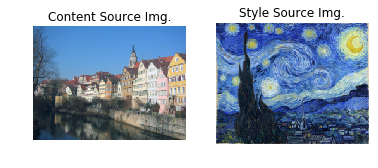

After 1 iteration:


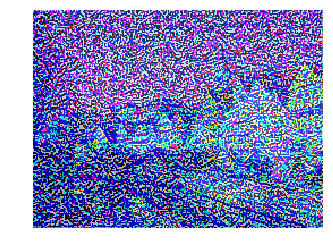

After 31 iteration:


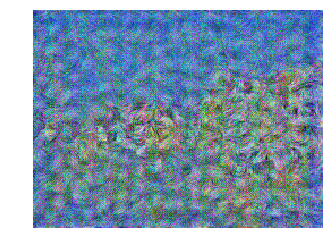

After 61 iteration:


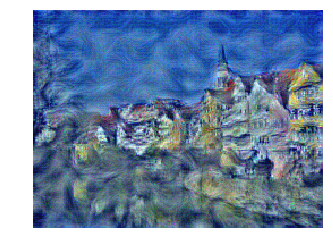

After 91 iteration:


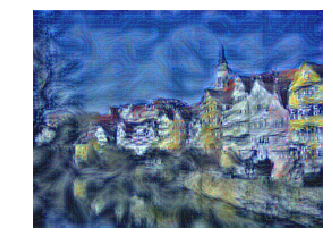

After 121 iteration:


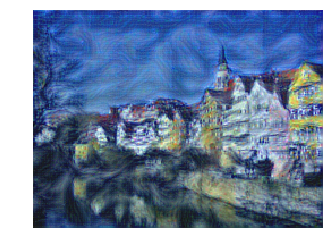

After 151 iteration:


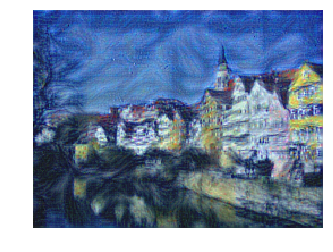

After 181 iteration:


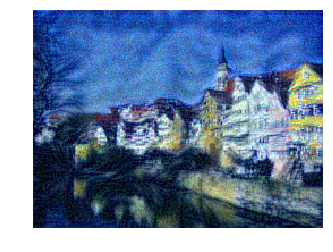

After 211 iteration:


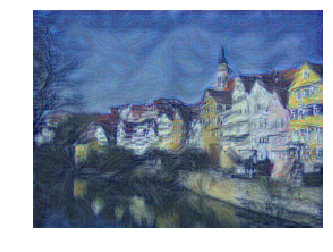

Final image:


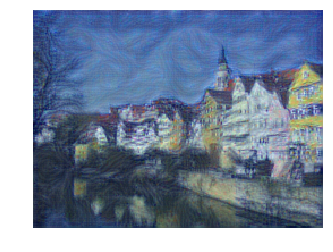

In [112]:
# get content and style images
content_image = preprocess(PIL.Image.open('./datasets/style_images/tubingen.jpg'), 192)
style_image = preprocess(PIL.Image.open('./datasets/style_images/starry_night.jpg'), 192)

# show original images
show_images(content_image, style_image)

# Composition VII + Tubingen
params1 = {
    'model': model,
    'content_image' : content_image,
    'style_image' : style_image,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

image = style_transfer(**params1)

# show combined results
print('Final image:')
show_image(image)